# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

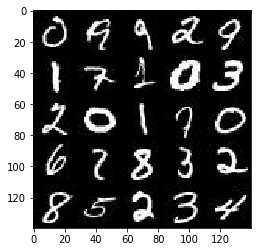

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

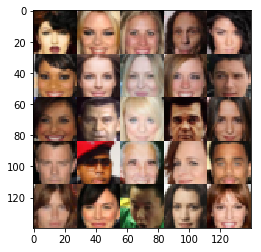

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels])
    inputs_z = tf.placeholder(tf.float32, [None, z_dim])
    learning_rate = tf.placeholder(tf.float32, None)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha = .2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse = reuse):
        # Input image 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        x1 = tf.maximum(alpha*x1, x1)
        # x1 is 14x14x64
        x2 = tf.layers.conv2d(x1, 128, 5, strides = 2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training = True)
        x2 = tf.maximum(alpha*x2, x2)
        # x2 is 7x7x128
        x3 = tf.layers.conv2d(x2, 256, 5, strides= 2, padding= 'same')
        x3 = tf.layers.batch_normalization(x3, training= True)
        x3 = tf.maximum(alpha*x3, x3)
        # x3 is 4x4x256
        
        dims = x3.shape[1]*x3.shape[2]*x3.shape[3]
        flat = tf.reshape(x3, (-1,int(dims)))
        
        logits = tf.layers.dense(flat,1, activation=None)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [55]:
def generator(z, out_channel_dim, is_train=True, alpha = .2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1,7,7,512))
        x1 = tf.layers.batch_normalization(x1, training= is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # x1 7x7x1024
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding = 'same')
        x2 = tf.layers.batch_normalization(x2, training= is_train)
        x2 = tf.maximum(alpha*x2, x2)
        # x2 14x14x512
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding= 'same')
        x3 = tf.layers.batch_normalization(x3, training= is_train)
        x3 = tf.maximum(alpha*x3, x3)
        # x3 28x28x256
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 1, padding = 'same')
        # logits 28x28x3
        
        out = tf.tanh(logits)
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [56]:
def model_loss(input_real, input_z, out_channel_dim, alpha = .2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train= True, alpha = alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False, alpha= alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse= True, alpha= alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [57]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [58]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [71]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha = .2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3], alpha)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images = batch_images*2
                
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict = {inputs_real: batch_images, inputs_z: batch_z,\
                                                       lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {inputs_real: batch_images, inputs_z: batch_z,\
                                                       lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                     
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 1, inputs_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0145... Generator Loss: 5.7620
Epoch 1/2... Discriminator Loss: 0.0295... Generator Loss: 4.5458
Epoch 1/2... Discriminator Loss: 0.0406... Generator Loss: 3.5043
Epoch 1/2... Discriminator Loss: 0.0234... Generator Loss: 4.1965
Epoch 1/2... Discriminator Loss: 2.2186... Generator Loss: 0.2820
Epoch 1/2... Discriminator Loss: 0.2669... Generator Loss: 7.5370
Epoch 1/2... Discriminator Loss: 0.8597... Generator Loss: 1.2113
Epoch 1/2... Discriminator Loss: 1.7554... Generator Loss: 1.3407
Epoch 1/2... Discriminator Loss: 1.5016... Generator Loss: 0.4767
Epoch 1/2... Discriminator Loss: 1.8710... Generator Loss: 0.2221


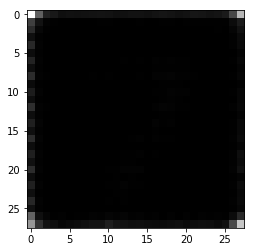

Epoch 1/2... Discriminator Loss: 1.0871... Generator Loss: 0.6270
Epoch 1/2... Discriminator Loss: 1.2657... Generator Loss: 0.6707
Epoch 1/2... Discriminator Loss: 1.2711... Generator Loss: 0.5220
Epoch 1/2... Discriminator Loss: 1.3052... Generator Loss: 0.7709
Epoch 1/2... Discriminator Loss: 1.3499... Generator Loss: 0.7499
Epoch 1/2... Discriminator Loss: 1.0787... Generator Loss: 0.7876
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 0.7818
Epoch 1/2... Discriminator Loss: 1.7582... Generator Loss: 0.3096
Epoch 1/2... Discriminator Loss: 1.2827... Generator Loss: 0.6825
Epoch 1/2... Discriminator Loss: 1.2524... Generator Loss: 0.9721


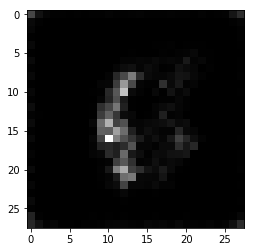

Epoch 1/2... Discriminator Loss: 1.0502... Generator Loss: 0.7491
Epoch 1/2... Discriminator Loss: 1.2281... Generator Loss: 0.5612
Epoch 1/2... Discriminator Loss: 1.2212... Generator Loss: 0.5956
Epoch 1/2... Discriminator Loss: 1.0938... Generator Loss: 0.7304
Epoch 1/2... Discriminator Loss: 1.0946... Generator Loss: 1.5354
Epoch 1/2... Discriminator Loss: 1.2368... Generator Loss: 0.8543
Epoch 1/2... Discriminator Loss: 1.0625... Generator Loss: 0.8175
Epoch 1/2... Discriminator Loss: 1.0150... Generator Loss: 1.0241
Epoch 1/2... Discriminator Loss: 1.0991... Generator Loss: 0.7526
Epoch 1/2... Discriminator Loss: 1.0876... Generator Loss: 0.7101


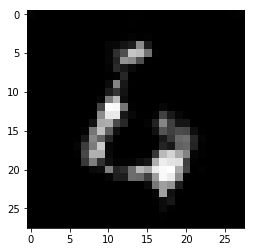

Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 0.7884
Epoch 1/2... Discriminator Loss: 1.2354... Generator Loss: 1.5184
Epoch 1/2... Discriminator Loss: 1.0550... Generator Loss: 0.7365
Epoch 1/2... Discriminator Loss: 1.2516... Generator Loss: 0.4887
Epoch 1/2... Discriminator Loss: 1.0828... Generator Loss: 0.7972
Epoch 1/2... Discriminator Loss: 0.8523... Generator Loss: 1.1503
Epoch 1/2... Discriminator Loss: 1.1178... Generator Loss: 1.0384
Epoch 1/2... Discriminator Loss: 1.0304... Generator Loss: 0.9051
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 1.0387
Epoch 1/2... Discriminator Loss: 1.0365... Generator Loss: 0.7525


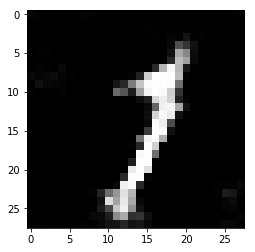

Epoch 1/2... Discriminator Loss: 1.1528... Generator Loss: 1.5284
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 0.7165
Epoch 1/2... Discriminator Loss: 1.0269... Generator Loss: 1.1193
Epoch 1/2... Discriminator Loss: 1.2592... Generator Loss: 0.4674
Epoch 1/2... Discriminator Loss: 1.0926... Generator Loss: 0.6835
Epoch 1/2... Discriminator Loss: 1.0247... Generator Loss: 1.1032
Epoch 1/2... Discriminator Loss: 0.9836... Generator Loss: 1.0121
Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 0.7255
Epoch 1/2... Discriminator Loss: 1.2310... Generator Loss: 0.6989
Epoch 1/2... Discriminator Loss: 1.0687... Generator Loss: 0.7510


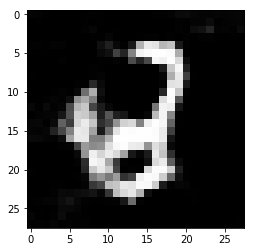

Epoch 1/2... Discriminator Loss: 1.4613... Generator Loss: 0.3452
Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 0.9242
Epoch 1/2... Discriminator Loss: 0.9168... Generator Loss: 0.9383
Epoch 1/2... Discriminator Loss: 0.9746... Generator Loss: 1.0962
Epoch 1/2... Discriminator Loss: 0.9588... Generator Loss: 0.7565
Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 0.6666
Epoch 1/2... Discriminator Loss: 1.1083... Generator Loss: 0.6709
Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 0.7066
Epoch 1/2... Discriminator Loss: 0.8570... Generator Loss: 0.9940
Epoch 1/2... Discriminator Loss: 1.5153... Generator Loss: 0.3332


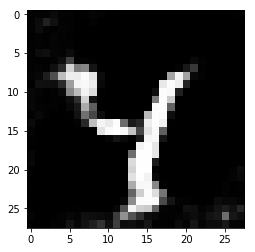

Epoch 1/2... Discriminator Loss: 0.9250... Generator Loss: 0.9549
Epoch 1/2... Discriminator Loss: 1.4473... Generator Loss: 0.4141
Epoch 1/2... Discriminator Loss: 1.0545... Generator Loss: 0.7168
Epoch 1/2... Discriminator Loss: 0.9248... Generator Loss: 0.7614
Epoch 1/2... Discriminator Loss: 1.0372... Generator Loss: 0.9032
Epoch 1/2... Discriminator Loss: 1.1438... Generator Loss: 0.6519
Epoch 1/2... Discriminator Loss: 1.0302... Generator Loss: 1.2723
Epoch 1/2... Discriminator Loss: 1.1777... Generator Loss: 0.6835
Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 0.7040
Epoch 1/2... Discriminator Loss: 1.0419... Generator Loss: 1.1522


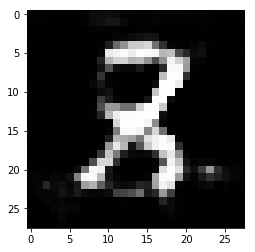

Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 0.5150
Epoch 1/2... Discriminator Loss: 1.0455... Generator Loss: 0.7034
Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 0.5057
Epoch 1/2... Discriminator Loss: 0.9341... Generator Loss: 1.7213
Epoch 1/2... Discriminator Loss: 1.1384... Generator Loss: 0.9288
Epoch 1/2... Discriminator Loss: 1.3308... Generator Loss: 0.4089
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.5391
Epoch 1/2... Discriminator Loss: 1.0616... Generator Loss: 0.9843
Epoch 1/2... Discriminator Loss: 1.2668... Generator Loss: 0.6303
Epoch 1/2... Discriminator Loss: 0.8732... Generator Loss: 1.0665


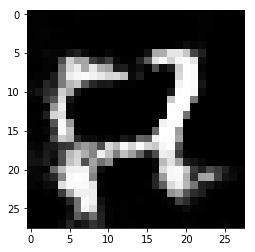

Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 0.4529
Epoch 1/2... Discriminator Loss: 1.0156... Generator Loss: 0.6504
Epoch 1/2... Discriminator Loss: 1.0302... Generator Loss: 1.0224
Epoch 1/2... Discriminator Loss: 1.3941... Generator Loss: 0.4021
Epoch 1/2... Discriminator Loss: 1.0315... Generator Loss: 0.9062
Epoch 1/2... Discriminator Loss: 1.0755... Generator Loss: 0.6318
Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 1.1264
Epoch 1/2... Discriminator Loss: 1.2437... Generator Loss: 0.6683
Epoch 1/2... Discriminator Loss: 1.1065... Generator Loss: 0.5898
Epoch 1/2... Discriminator Loss: 1.1642... Generator Loss: 0.5473


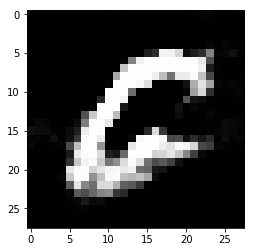

Epoch 1/2... Discriminator Loss: 1.5782... Generator Loss: 0.3059
Epoch 1/2... Discriminator Loss: 1.2409... Generator Loss: 0.5357
Epoch 1/2... Discriminator Loss: 1.3124... Generator Loss: 0.4087
Epoch 1/2... Discriminator Loss: 0.9923... Generator Loss: 0.8438
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 0.6842
Epoch 1/2... Discriminator Loss: 0.8970... Generator Loss: 1.1059
Epoch 1/2... Discriminator Loss: 1.0047... Generator Loss: 1.1937
Epoch 1/2... Discriminator Loss: 0.9696... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 1.0632... Generator Loss: 0.6530
Epoch 1/2... Discriminator Loss: 1.0133... Generator Loss: 0.7365


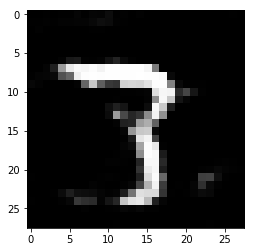

Epoch 1/2... Discriminator Loss: 1.1506... Generator Loss: 0.6103
Epoch 1/2... Discriminator Loss: 1.4048... Generator Loss: 0.3953
Epoch 1/2... Discriminator Loss: 1.1662... Generator Loss: 0.6775
Epoch 1/2... Discriminator Loss: 1.2787... Generator Loss: 0.4492
Epoch 1/2... Discriminator Loss: 0.8835... Generator Loss: 1.0599
Epoch 1/2... Discriminator Loss: 0.9664... Generator Loss: 0.9959
Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 0.5543
Epoch 1/2... Discriminator Loss: 1.7719... Generator Loss: 0.2316
Epoch 1/2... Discriminator Loss: 0.8920... Generator Loss: 1.5217
Epoch 1/2... Discriminator Loss: 0.8686... Generator Loss: 0.9101


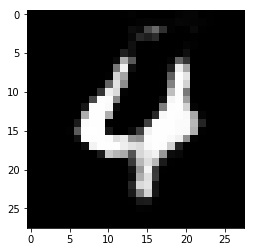

Epoch 1/2... Discriminator Loss: 0.8905... Generator Loss: 0.9330
Epoch 1/2... Discriminator Loss: 0.7258... Generator Loss: 1.1571
Epoch 1/2... Discriminator Loss: 0.8307... Generator Loss: 0.7690
Epoch 1/2... Discriminator Loss: 1.7217... Generator Loss: 1.4702
Epoch 1/2... Discriminator Loss: 1.1079... Generator Loss: 0.6832
Epoch 1/2... Discriminator Loss: 1.0112... Generator Loss: 1.0752
Epoch 1/2... Discriminator Loss: 0.8633... Generator Loss: 1.0817
Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 0.6239
Epoch 1/2... Discriminator Loss: 0.9337... Generator Loss: 0.9931
Epoch 1/2... Discriminator Loss: 1.2077... Generator Loss: 0.5072


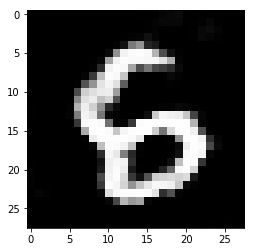

Epoch 1/2... Discriminator Loss: 0.9320... Generator Loss: 1.1401
Epoch 1/2... Discriminator Loss: 0.8158... Generator Loss: 1.3853
Epoch 1/2... Discriminator Loss: 1.0957... Generator Loss: 1.7013
Epoch 1/2... Discriminator Loss: 0.8968... Generator Loss: 1.2008
Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 0.4652
Epoch 1/2... Discriminator Loss: 2.2471... Generator Loss: 0.1469
Epoch 1/2... Discriminator Loss: 0.8818... Generator Loss: 0.8886
Epoch 1/2... Discriminator Loss: 0.8998... Generator Loss: 0.8457
Epoch 1/2... Discriminator Loss: 1.4996... Generator Loss: 0.3513
Epoch 1/2... Discriminator Loss: 0.8335... Generator Loss: 1.7244


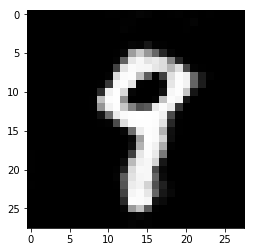

Epoch 1/2... Discriminator Loss: 0.9416... Generator Loss: 0.7936
Epoch 1/2... Discriminator Loss: 0.7741... Generator Loss: 0.8502
Epoch 1/2... Discriminator Loss: 1.4163... Generator Loss: 1.9610
Epoch 1/2... Discriminator Loss: 1.1833... Generator Loss: 0.7335
Epoch 1/2... Discriminator Loss: 1.1854... Generator Loss: 0.5291
Epoch 1/2... Discriminator Loss: 1.0695... Generator Loss: 0.7071
Epoch 1/2... Discriminator Loss: 1.1637... Generator Loss: 0.5988
Epoch 1/2... Discriminator Loss: 2.9093... Generator Loss: 0.0782
Epoch 1/2... Discriminator Loss: 0.8866... Generator Loss: 0.8753
Epoch 1/2... Discriminator Loss: 1.0904... Generator Loss: 0.5631


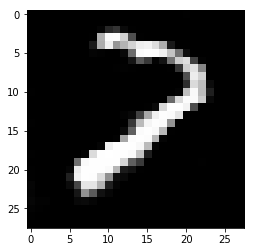

Epoch 1/2... Discriminator Loss: 1.4786... Generator Loss: 0.3439
Epoch 1/2... Discriminator Loss: 1.0524... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 1.1461... Generator Loss: 0.5858
Epoch 1/2... Discriminator Loss: 0.9813... Generator Loss: 0.6894
Epoch 1/2... Discriminator Loss: 0.8937... Generator Loss: 0.7836
Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 0.5534
Epoch 1/2... Discriminator Loss: 0.8046... Generator Loss: 0.9577
Epoch 1/2... Discriminator Loss: 0.9314... Generator Loss: 0.9726
Epoch 1/2... Discriminator Loss: 2.5106... Generator Loss: 2.8792
Epoch 1/2... Discriminator Loss: 1.0954... Generator Loss: 0.6994


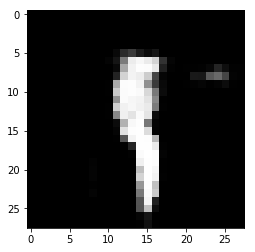

Epoch 1/2... Discriminator Loss: 1.0922... Generator Loss: 0.9938
Epoch 1/2... Discriminator Loss: 0.8298... Generator Loss: 0.8738
Epoch 1/2... Discriminator Loss: 1.0076... Generator Loss: 0.8030
Epoch 1/2... Discriminator Loss: 0.6245... Generator Loss: 1.3743
Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.4741
Epoch 1/2... Discriminator Loss: 0.8391... Generator Loss: 0.9042
Epoch 1/2... Discriminator Loss: 1.2517... Generator Loss: 0.4843
Epoch 1/2... Discriminator Loss: 1.0396... Generator Loss: 0.6048
Epoch 1/2... Discriminator Loss: 0.9804... Generator Loss: 0.8777
Epoch 1/2... Discriminator Loss: 1.3273... Generator Loss: 0.4053


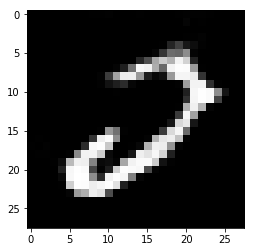

Epoch 1/2... Discriminator Loss: 1.4410... Generator Loss: 0.3611
Epoch 1/2... Discriminator Loss: 0.7712... Generator Loss: 1.1712
Epoch 1/2... Discriminator Loss: 0.8865... Generator Loss: 1.6690
Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 0.5455
Epoch 1/2... Discriminator Loss: 0.7990... Generator Loss: 0.8086
Epoch 1/2... Discriminator Loss: 0.9212... Generator Loss: 0.7010
Epoch 1/2... Discriminator Loss: 2.0565... Generator Loss: 0.1938
Epoch 1/2... Discriminator Loss: 1.4358... Generator Loss: 0.3780
Epoch 1/2... Discriminator Loss: 1.0482... Generator Loss: 0.6124
Epoch 1/2... Discriminator Loss: 1.3432... Generator Loss: 0.4709


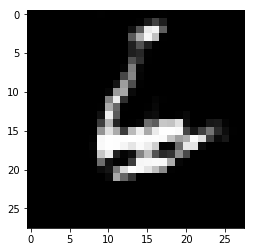

Epoch 1/2... Discriminator Loss: 1.6959... Generator Loss: 2.9615
Epoch 1/2... Discriminator Loss: 1.2344... Generator Loss: 0.5119
Epoch 1/2... Discriminator Loss: 0.8473... Generator Loss: 1.1541
Epoch 1/2... Discriminator Loss: 0.7789... Generator Loss: 1.0222
Epoch 1/2... Discriminator Loss: 0.9916... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 0.9346... Generator Loss: 0.8961
Epoch 1/2... Discriminator Loss: 1.2266... Generator Loss: 2.2271
Epoch 1/2... Discriminator Loss: 1.3029... Generator Loss: 0.5801
Epoch 1/2... Discriminator Loss: 0.9645... Generator Loss: 0.7739
Epoch 1/2... Discriminator Loss: 1.4251... Generator Loss: 0.3542


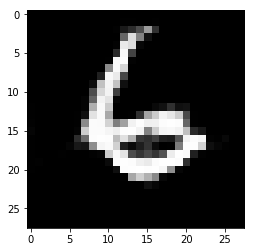

Epoch 1/2... Discriminator Loss: 0.7814... Generator Loss: 1.1657
Epoch 1/2... Discriminator Loss: 1.2688... Generator Loss: 0.4586
Epoch 1/2... Discriminator Loss: 0.8496... Generator Loss: 1.0307
Epoch 1/2... Discriminator Loss: 0.6309... Generator Loss: 1.6929
Epoch 1/2... Discriminator Loss: 1.4708... Generator Loss: 0.3934
Epoch 1/2... Discriminator Loss: 1.4436... Generator Loss: 0.3339
Epoch 1/2... Discriminator Loss: 0.5952... Generator Loss: 1.5440
Epoch 2/2... Discriminator Loss: 0.5884... Generator Loss: 1.3873
Epoch 2/2... Discriminator Loss: 0.9585... Generator Loss: 0.8568
Epoch 2/2... Discriminator Loss: 1.6115... Generator Loss: 0.3203


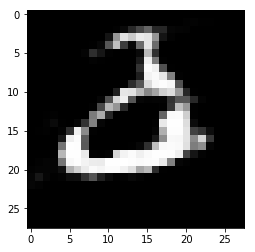

Epoch 2/2... Discriminator Loss: 0.9858... Generator Loss: 2.0790
Epoch 2/2... Discriminator Loss: 0.6267... Generator Loss: 1.1551
Epoch 2/2... Discriminator Loss: 1.0352... Generator Loss: 0.5837
Epoch 2/2... Discriminator Loss: 0.9827... Generator Loss: 0.6388
Epoch 2/2... Discriminator Loss: 0.8960... Generator Loss: 0.6879
Epoch 2/2... Discriminator Loss: 0.7467... Generator Loss: 0.8748
Epoch 2/2... Discriminator Loss: 0.7157... Generator Loss: 1.0335
Epoch 2/2... Discriminator Loss: 1.7325... Generator Loss: 0.2522
Epoch 2/2... Discriminator Loss: 0.6152... Generator Loss: 1.9649
Epoch 2/2... Discriminator Loss: 1.4819... Generator Loss: 0.3349


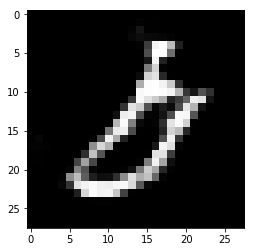

Epoch 2/2... Discriminator Loss: 0.7036... Generator Loss: 1.1749
Epoch 2/2... Discriminator Loss: 0.5846... Generator Loss: 1.1300
Epoch 2/2... Discriminator Loss: 1.0896... Generator Loss: 0.5977
Epoch 2/2... Discriminator Loss: 0.8367... Generator Loss: 0.9213
Epoch 2/2... Discriminator Loss: 0.9389... Generator Loss: 0.8257
Epoch 2/2... Discriminator Loss: 0.8009... Generator Loss: 0.7979
Epoch 2/2... Discriminator Loss: 0.6426... Generator Loss: 1.1580
Epoch 2/2... Discriminator Loss: 0.8066... Generator Loss: 0.8051
Epoch 2/2... Discriminator Loss: 0.5335... Generator Loss: 1.3180
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.3709


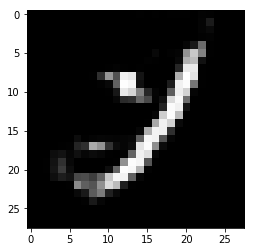

Epoch 2/2... Discriminator Loss: 1.8892... Generator Loss: 0.2169
Epoch 2/2... Discriminator Loss: 0.9458... Generator Loss: 0.8906
Epoch 2/2... Discriminator Loss: 0.7785... Generator Loss: 0.8331
Epoch 2/2... Discriminator Loss: 0.8898... Generator Loss: 0.7866
Epoch 2/2... Discriminator Loss: 0.8474... Generator Loss: 0.9123
Epoch 2/2... Discriminator Loss: 0.9044... Generator Loss: 0.7439
Epoch 2/2... Discriminator Loss: 1.0653... Generator Loss: 2.5761
Epoch 2/2... Discriminator Loss: 1.4376... Generator Loss: 0.3349
Epoch 2/2... Discriminator Loss: 1.1721... Generator Loss: 0.4726
Epoch 2/2... Discriminator Loss: 1.5619... Generator Loss: 0.3472


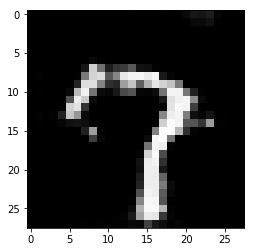

Epoch 2/2... Discriminator Loss: 0.9328... Generator Loss: 0.6292
Epoch 2/2... Discriminator Loss: 0.8659... Generator Loss: 1.7706
Epoch 2/2... Discriminator Loss: 1.7859... Generator Loss: 0.3133
Epoch 2/2... Discriminator Loss: 1.1526... Generator Loss: 0.6406
Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 1.1010
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.3609
Epoch 2/2... Discriminator Loss: 0.6238... Generator Loss: 1.8468
Epoch 2/2... Discriminator Loss: 1.7235... Generator Loss: 0.2817
Epoch 2/2... Discriminator Loss: 0.6150... Generator Loss: 1.5546
Epoch 2/2... Discriminator Loss: 0.5931... Generator Loss: 1.4775


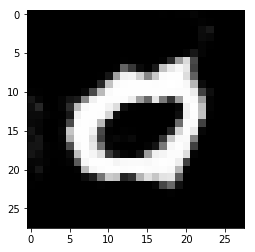

Epoch 2/2... Discriminator Loss: 1.1281... Generator Loss: 0.5300
Epoch 2/2... Discriminator Loss: 0.8494... Generator Loss: 0.7157
Epoch 2/2... Discriminator Loss: 0.6861... Generator Loss: 1.3197
Epoch 2/2... Discriminator Loss: 0.4471... Generator Loss: 1.7437
Epoch 2/2... Discriminator Loss: 0.7082... Generator Loss: 1.0578
Epoch 2/2... Discriminator Loss: 0.8910... Generator Loss: 0.7558
Epoch 2/2... Discriminator Loss: 0.9982... Generator Loss: 0.6423
Epoch 2/2... Discriminator Loss: 0.9596... Generator Loss: 0.6533
Epoch 2/2... Discriminator Loss: 0.7413... Generator Loss: 1.3436
Epoch 2/2... Discriminator Loss: 0.8032... Generator Loss: 1.3606


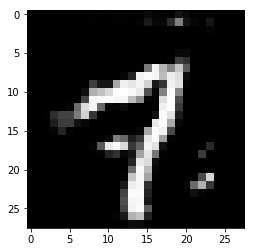

Epoch 2/2... Discriminator Loss: 0.7592... Generator Loss: 0.8960
Epoch 2/2... Discriminator Loss: 0.6818... Generator Loss: 0.9470
Epoch 2/2... Discriminator Loss: 0.8249... Generator Loss: 0.8187
Epoch 2/2... Discriminator Loss: 0.5940... Generator Loss: 2.3818
Epoch 2/2... Discriminator Loss: 0.9261... Generator Loss: 0.6866
Epoch 2/2... Discriminator Loss: 0.6673... Generator Loss: 1.0713
Epoch 2/2... Discriminator Loss: 0.8145... Generator Loss: 0.8154
Epoch 2/2... Discriminator Loss: 0.8851... Generator Loss: 0.6943
Epoch 2/2... Discriminator Loss: 0.7896... Generator Loss: 0.9886
Epoch 2/2... Discriminator Loss: 1.0407... Generator Loss: 1.1298


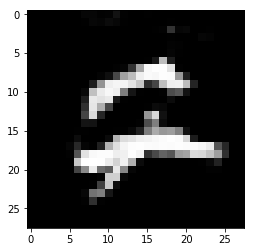

Epoch 2/2... Discriminator Loss: 0.8145... Generator Loss: 0.8112
Epoch 2/2... Discriminator Loss: 0.4827... Generator Loss: 1.6215
Epoch 2/2... Discriminator Loss: 0.7089... Generator Loss: 1.0135
Epoch 2/2... Discriminator Loss: 0.8790... Generator Loss: 0.7453
Epoch 2/2... Discriminator Loss: 0.7297... Generator Loss: 0.9118
Epoch 2/2... Discriminator Loss: 0.5601... Generator Loss: 1.1999
Epoch 2/2... Discriminator Loss: 0.6408... Generator Loss: 1.0902
Epoch 2/2... Discriminator Loss: 0.5852... Generator Loss: 1.1395
Epoch 2/2... Discriminator Loss: 1.1391... Generator Loss: 2.2805
Epoch 2/2... Discriminator Loss: 0.9663... Generator Loss: 0.7923


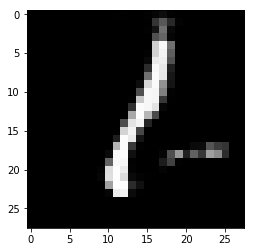

Epoch 2/2... Discriminator Loss: 0.3377... Generator Loss: 2.3116
Epoch 2/2... Discriminator Loss: 0.4807... Generator Loss: 1.5428
Epoch 2/2... Discriminator Loss: 0.9301... Generator Loss: 0.7394
Epoch 2/2... Discriminator Loss: 0.7249... Generator Loss: 2.1548
Epoch 2/2... Discriminator Loss: 0.7846... Generator Loss: 1.4166
Epoch 2/2... Discriminator Loss: 1.2990... Generator Loss: 2.4299
Epoch 2/2... Discriminator Loss: 0.9833... Generator Loss: 0.9240
Epoch 2/2... Discriminator Loss: 0.5950... Generator Loss: 1.1332
Epoch 2/2... Discriminator Loss: 0.8009... Generator Loss: 0.8059
Epoch 2/2... Discriminator Loss: 0.9438... Generator Loss: 0.6897


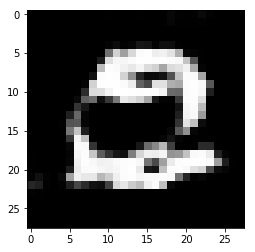

Epoch 2/2... Discriminator Loss: 1.1148... Generator Loss: 0.5645
Epoch 2/2... Discriminator Loss: 0.7042... Generator Loss: 1.0175
Epoch 2/2... Discriminator Loss: 0.6752... Generator Loss: 0.9416
Epoch 2/2... Discriminator Loss: 0.8654... Generator Loss: 0.9111
Epoch 2/2... Discriminator Loss: 0.7052... Generator Loss: 0.9948
Epoch 2/2... Discriminator Loss: 0.5045... Generator Loss: 1.3408
Epoch 2/2... Discriminator Loss: 0.5257... Generator Loss: 1.5492
Epoch 2/2... Discriminator Loss: 0.6906... Generator Loss: 1.3467
Epoch 2/2... Discriminator Loss: 1.8976... Generator Loss: 0.2493
Epoch 2/2... Discriminator Loss: 1.1641... Generator Loss: 0.5224


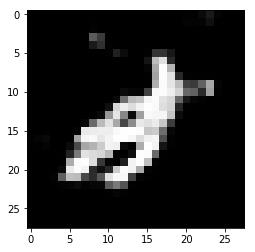

Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 0.7636
Epoch 2/2... Discriminator Loss: 0.5078... Generator Loss: 1.4175
Epoch 2/2... Discriminator Loss: 0.5110... Generator Loss: 1.2977
Epoch 2/2... Discriminator Loss: 0.9998... Generator Loss: 0.6483
Epoch 2/2... Discriminator Loss: 0.8357... Generator Loss: 1.1122
Epoch 2/2... Discriminator Loss: 0.8293... Generator Loss: 0.7907
Epoch 2/2... Discriminator Loss: 0.6278... Generator Loss: 1.0944
Epoch 2/2... Discriminator Loss: 0.5706... Generator Loss: 1.1365
Epoch 2/2... Discriminator Loss: 0.8441... Generator Loss: 0.9250
Epoch 2/2... Discriminator Loss: 0.6092... Generator Loss: 1.5849


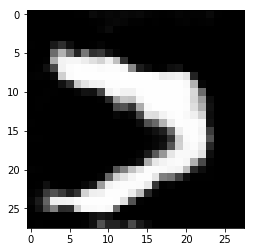

Epoch 2/2... Discriminator Loss: 0.6580... Generator Loss: 1.4606
Epoch 2/2... Discriminator Loss: 0.5438... Generator Loss: 1.9130
Epoch 2/2... Discriminator Loss: 0.6313... Generator Loss: 1.3903
Epoch 2/2... Discriminator Loss: 1.0442... Generator Loss: 0.5986
Epoch 2/2... Discriminator Loss: 0.4136... Generator Loss: 1.5329
Epoch 2/2... Discriminator Loss: 0.5901... Generator Loss: 1.9752
Epoch 2/2... Discriminator Loss: 0.5279... Generator Loss: 1.3181
Epoch 2/2... Discriminator Loss: 0.5167... Generator Loss: 1.2935
Epoch 2/2... Discriminator Loss: 0.5683... Generator Loss: 1.1103
Epoch 2/2... Discriminator Loss: 1.2235... Generator Loss: 0.4897


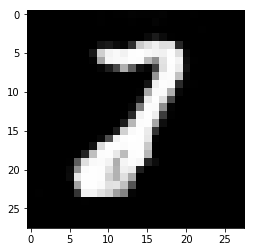

Epoch 2/2... Discriminator Loss: 0.7334... Generator Loss: 2.4837
Epoch 2/2... Discriminator Loss: 0.6362... Generator Loss: 1.6104
Epoch 2/2... Discriminator Loss: 0.6821... Generator Loss: 1.2391
Epoch 2/2... Discriminator Loss: 0.5998... Generator Loss: 1.1261
Epoch 2/2... Discriminator Loss: 0.5099... Generator Loss: 1.6110
Epoch 2/2... Discriminator Loss: 0.5250... Generator Loss: 1.2600
Epoch 2/2... Discriminator Loss: 0.8016... Generator Loss: 1.5387
Epoch 2/2... Discriminator Loss: 0.7857... Generator Loss: 0.9588
Epoch 2/2... Discriminator Loss: 0.3732... Generator Loss: 1.8665
Epoch 2/2... Discriminator Loss: 1.2477... Generator Loss: 0.4845


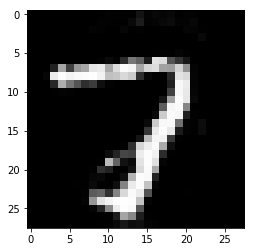

Epoch 2/2... Discriminator Loss: 0.8951... Generator Loss: 0.7826
Epoch 2/2... Discriminator Loss: 0.8689... Generator Loss: 0.7773
Epoch 2/2... Discriminator Loss: 0.5643... Generator Loss: 1.7874
Epoch 2/2... Discriminator Loss: 0.6183... Generator Loss: 2.6212
Epoch 2/2... Discriminator Loss: 0.7358... Generator Loss: 1.0511
Epoch 2/2... Discriminator Loss: 0.5576... Generator Loss: 1.2228
Epoch 2/2... Discriminator Loss: 0.6451... Generator Loss: 1.0453
Epoch 2/2... Discriminator Loss: 0.7100... Generator Loss: 1.2691
Epoch 2/2... Discriminator Loss: 0.4406... Generator Loss: 1.4838
Epoch 2/2... Discriminator Loss: 0.6076... Generator Loss: 1.2306


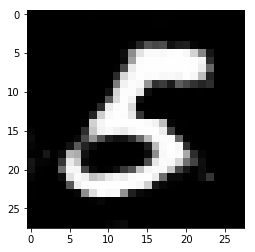

Epoch 2/2... Discriminator Loss: 0.6942... Generator Loss: 1.0948
Epoch 2/2... Discriminator Loss: 0.6503... Generator Loss: 0.9750
Epoch 2/2... Discriminator Loss: 0.7055... Generator Loss: 1.0890
Epoch 2/2... Discriminator Loss: 0.5766... Generator Loss: 1.1221
Epoch 2/2... Discriminator Loss: 0.6873... Generator Loss: 1.0800
Epoch 2/2... Discriminator Loss: 0.5626... Generator Loss: 1.0720
Epoch 2/2... Discriminator Loss: 0.5586... Generator Loss: 1.1479
Epoch 2/2... Discriminator Loss: 0.2934... Generator Loss: 2.5531
Epoch 2/2... Discriminator Loss: 1.1620... Generator Loss: 0.5732
Epoch 2/2... Discriminator Loss: 0.4924... Generator Loss: 2.0108


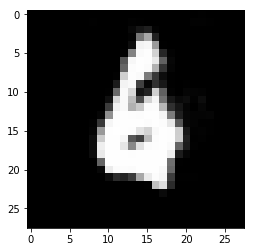

Epoch 2/2... Discriminator Loss: 0.4217... Generator Loss: 2.3414
Epoch 2/2... Discriminator Loss: 0.9624... Generator Loss: 0.7689
Epoch 2/2... Discriminator Loss: 0.8354... Generator Loss: 0.9986
Epoch 2/2... Discriminator Loss: 1.4736... Generator Loss: 0.3827
Epoch 2/2... Discriminator Loss: 0.5500... Generator Loss: 1.3732
Epoch 2/2... Discriminator Loss: 0.5643... Generator Loss: 1.2222
Epoch 2/2... Discriminator Loss: 0.4641... Generator Loss: 1.5783
Epoch 2/2... Discriminator Loss: 0.7797... Generator Loss: 1.0429
Epoch 2/2... Discriminator Loss: 0.7753... Generator Loss: 1.3407
Epoch 2/2... Discriminator Loss: 0.5955... Generator Loss: 1.1421


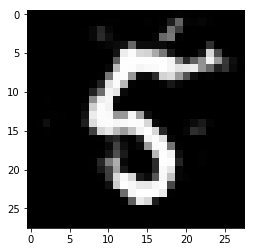

Epoch 2/2... Discriminator Loss: 1.3435... Generator Loss: 0.4523
Epoch 2/2... Discriminator Loss: 0.9412... Generator Loss: 0.6964
Epoch 2/2... Discriminator Loss: 0.7899... Generator Loss: 0.9179
Epoch 2/2... Discriminator Loss: 0.5888... Generator Loss: 1.1962
Epoch 2/2... Discriminator Loss: 0.8397... Generator Loss: 0.8846
Epoch 2/2... Discriminator Loss: 1.2299... Generator Loss: 0.5546
Epoch 2/2... Discriminator Loss: 0.4877... Generator Loss: 1.4626
Epoch 2/2... Discriminator Loss: 0.4970... Generator Loss: 1.9027
Epoch 2/2... Discriminator Loss: 0.6076... Generator Loss: 1.8085
Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 0.8486


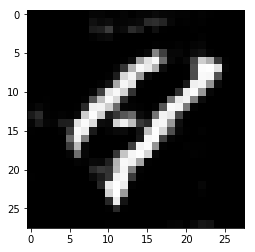

Epoch 2/2... Discriminator Loss: 0.5211... Generator Loss: 1.4042
Epoch 2/2... Discriminator Loss: 0.4246... Generator Loss: 1.5710
Epoch 2/2... Discriminator Loss: 0.6132... Generator Loss: 1.2428
Epoch 2/2... Discriminator Loss: 0.8452... Generator Loss: 0.8241
Epoch 2/2... Discriminator Loss: 0.8926... Generator Loss: 0.7426
Epoch 2/2... Discriminator Loss: 0.5962... Generator Loss: 1.3969
Epoch 2/2... Discriminator Loss: 1.2515... Generator Loss: 0.4622
Epoch 2/2... Discriminator Loss: 1.0198... Generator Loss: 0.7093
Epoch 2/2... Discriminator Loss: 0.7960... Generator Loss: 0.8930
Epoch 2/2... Discriminator Loss: 0.6059... Generator Loss: 1.2041


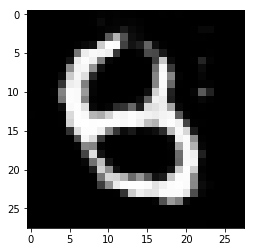

Epoch 2/2... Discriminator Loss: 0.5651... Generator Loss: 1.3042
Epoch 2/2... Discriminator Loss: 0.5274... Generator Loss: 1.3370
Epoch 2/2... Discriminator Loss: 0.9994... Generator Loss: 2.7081
Epoch 2/2... Discriminator Loss: 1.3397... Generator Loss: 0.4784
Epoch 2/2... Discriminator Loss: 0.5409... Generator Loss: 1.4185
Epoch 2/2... Discriminator Loss: 0.9008... Generator Loss: 0.7432
Epoch 2/2... Discriminator Loss: 0.6513... Generator Loss: 1.0359
Epoch 2/2... Discriminator Loss: 0.7873... Generator Loss: 0.9373
Epoch 2/2... Discriminator Loss: 0.7688... Generator Loss: 0.8829
Epoch 2/2... Discriminator Loss: 2.2350... Generator Loss: 0.2558


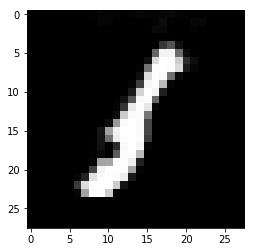

Epoch 2/2... Discriminator Loss: 0.7712... Generator Loss: 1.2846
Epoch 2/2... Discriminator Loss: 0.6684... Generator Loss: 1.2770
Epoch 2/2... Discriminator Loss: 1.0229... Generator Loss: 0.6786
Epoch 2/2... Discriminator Loss: 0.7624... Generator Loss: 1.1419
Epoch 2/2... Discriminator Loss: 0.7181... Generator Loss: 0.9188


In [73]:
batch_size = 32
z_dim = 100
learning_rate = .0002
beta1 = .5
alpha = .2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha = alpha)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.9621... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 0.7186... Generator Loss: 0.9595
Epoch 1/1... Discriminator Loss: 0.2150... Generator Loss: 3.3038
Epoch 1/1... Discriminator Loss: 0.2379... Generator Loss: 4.2068
Epoch 1/1... Discriminator Loss: 3.4306... Generator Loss: 0.0468
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.2114
Epoch 1/1... Discriminator Loss: 1.0914... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 0.6800... Generator Loss: 1.2769
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 1.8024
Epoch 1/1... Discriminator Loss: 0.4546... Generator Loss: 1.7491


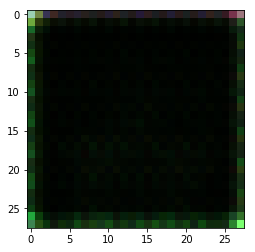

Epoch 1/1... Discriminator Loss: 0.7636... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 0.2567... Generator Loss: 4.7816
Epoch 1/1... Discriminator Loss: 2.0835... Generator Loss: 0.1794
Epoch 1/1... Discriminator Loss: 0.8525... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 0.0776... Generator Loss: 7.0871
Epoch 1/1... Discriminator Loss: 0.3576... Generator Loss: 2.0918
Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 0.8764
Epoch 1/1... Discriminator Loss: 0.1626... Generator Loss: 5.2834
Epoch 1/1... Discriminator Loss: 1.9510... Generator Loss: 0.2243
Epoch 1/1... Discriminator Loss: 0.1884... Generator Loss: 2.6265


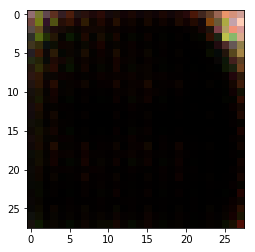

Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 0.4057... Generator Loss: 3.2882
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 0.3207
Epoch 1/1... Discriminator Loss: 0.4344... Generator Loss: 1.7333
Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 2.5880
Epoch 1/1... Discriminator Loss: 1.5890... Generator Loss: 0.3732
Epoch 1/1... Discriminator Loss: 0.5630... Generator Loss: 3.8112
Epoch 1/1... Discriminator Loss: 0.2861... Generator Loss: 7.5923
Epoch 1/1... Discriminator Loss: 1.6733... Generator Loss: 0.3403
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 0.6885


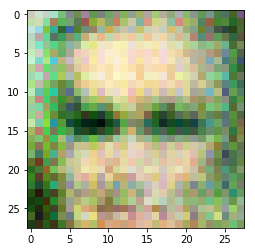

Epoch 1/1... Discriminator Loss: 1.1628... Generator Loss: 2.7061
Epoch 1/1... Discriminator Loss: 0.5204... Generator Loss: 1.7958
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 0.3108... Generator Loss: 2.8138
Epoch 1/1... Discriminator Loss: 0.6914... Generator Loss: 2.8933
Epoch 1/1... Discriminator Loss: 0.1743... Generator Loss: 3.5130
Epoch 1/1... Discriminator Loss: 3.2095... Generator Loss: 0.0573
Epoch 1/1... Discriminator Loss: 0.3288... Generator Loss: 2.1465
Epoch 1/1... Discriminator Loss: 0.3482... Generator Loss: 1.9762
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 1.1049


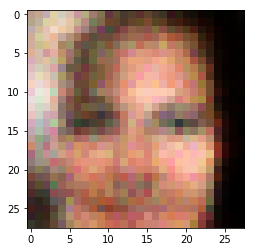

Epoch 1/1... Discriminator Loss: 0.1163... Generator Loss: 4.3264
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.4634
Epoch 1/1... Discriminator Loss: 0.3707... Generator Loss: 6.5141
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 3.5995
Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 1.1108
Epoch 1/1... Discriminator Loss: 0.6941... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 0.1984... Generator Loss: 2.7155
Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 0.4256... Generator Loss: 1.4430
Epoch 1/1... Discriminator Loss: 0.2465... Generator Loss: 6.0842


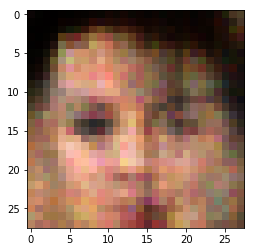

Epoch 1/1... Discriminator Loss: 0.3878... Generator Loss: 2.1553
Epoch 1/1... Discriminator Loss: 0.2607... Generator Loss: 3.0612
Epoch 1/1... Discriminator Loss: 2.5522... Generator Loss: 0.1527
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 2.0372... Generator Loss: 0.1780
Epoch 1/1... Discriminator Loss: 1.8629... Generator Loss: 1.5374
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 3.5547
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 2.0549
Epoch 1/1... Discriminator Loss: 0.7918... Generator Loss: 1.3549
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 4.3958


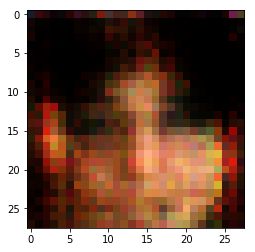

Epoch 1/1... Discriminator Loss: 0.3924... Generator Loss: 1.5567
Epoch 1/1... Discriminator Loss: 0.2041... Generator Loss: 3.1852
Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 0.2899... Generator Loss: 1.7336
Epoch 1/1... Discriminator Loss: 0.2211... Generator Loss: 2.3858
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 0.4741... Generator Loss: 3.3205
Epoch 1/1... Discriminator Loss: 0.1405... Generator Loss: 2.9206
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 0.4450... Generator Loss: 3.0933


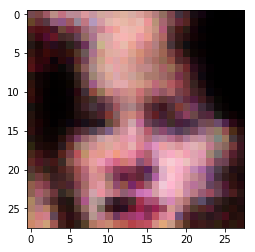

Epoch 1/1... Discriminator Loss: 0.5098... Generator Loss: 1.4708
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 2.9141
Epoch 1/1... Discriminator Loss: 0.3797... Generator Loss: 1.6444
Epoch 1/1... Discriminator Loss: 0.7967... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.6592... Generator Loss: 0.3923
Epoch 1/1... Discriminator Loss: 0.2003... Generator Loss: 4.2715
Epoch 1/1... Discriminator Loss: 0.1284... Generator Loss: 3.3141
Epoch 1/1... Discriminator Loss: 0.1311... Generator Loss: 4.2894
Epoch 1/1... Discriminator Loss: 0.5481... Generator Loss: 1.1932
Epoch 1/1... Discriminator Loss: 0.2447... Generator Loss: 2.1449


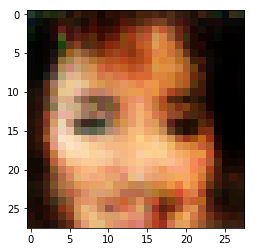

Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 1.0231
Epoch 1/1... Discriminator Loss: 0.2202... Generator Loss: 2.2657
Epoch 1/1... Discriminator Loss: 0.7116... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 0.3113... Generator Loss: 1.5672
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.4006
Epoch 1/1... Discriminator Loss: 1.9439... Generator Loss: 0.1964
Epoch 1/1... Discriminator Loss: 0.4089... Generator Loss: 1.6360
Epoch 1/1... Discriminator Loss: 0.3868... Generator Loss: 1.6068
Epoch 1/1... Discriminator Loss: 0.2579... Generator Loss: 4.1722


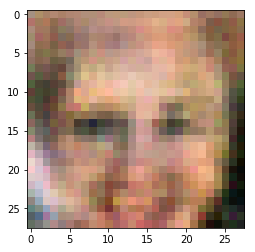

Epoch 1/1... Discriminator Loss: 0.6218... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 5.4534
Epoch 1/1... Discriminator Loss: 0.5714... Generator Loss: 1.1154
Epoch 1/1... Discriminator Loss: 0.2702... Generator Loss: 2.1712
Epoch 1/1... Discriminator Loss: 0.1228... Generator Loss: 3.2793
Epoch 1/1... Discriminator Loss: 0.2393... Generator Loss: 1.9754
Epoch 1/1... Discriminator Loss: 0.4795... Generator Loss: 1.2701
Epoch 1/1... Discriminator Loss: 0.3472... Generator Loss: 1.7847
Epoch 1/1... Discriminator Loss: 0.5167... Generator Loss: 5.2200
Epoch 1/1... Discriminator Loss: 0.1891... Generator Loss: 4.3759


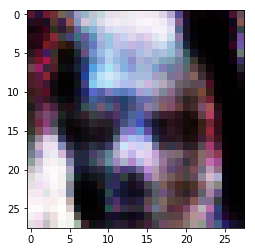

Epoch 1/1... Discriminator Loss: 0.0996... Generator Loss: 5.6159
Epoch 1/1... Discriminator Loss: 0.1195... Generator Loss: 3.9670
Epoch 1/1... Discriminator Loss: 0.1606... Generator Loss: 2.7938
Epoch 1/1... Discriminator Loss: 0.1683... Generator Loss: 2.6301
Epoch 1/1... Discriminator Loss: 0.1036... Generator Loss: 3.9362
Epoch 1/1... Discriminator Loss: 0.1231... Generator Loss: 3.1753
Epoch 1/1... Discriminator Loss: 3.3708... Generator Loss: 0.0473
Epoch 1/1... Discriminator Loss: 0.2353... Generator Loss: 2.2738
Epoch 1/1... Discriminator Loss: 0.8179... Generator Loss: 0.8715
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 0.6098


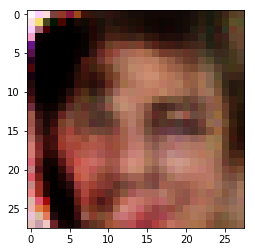

Epoch 1/1... Discriminator Loss: 0.3941... Generator Loss: 7.3620
Epoch 1/1... Discriminator Loss: 0.2131... Generator Loss: 5.1607
Epoch 1/1... Discriminator Loss: 0.4062... Generator Loss: 1.5733
Epoch 1/1... Discriminator Loss: 0.1157... Generator Loss: 5.1627
Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 6.0162
Epoch 1/1... Discriminator Loss: 0.4272... Generator Loss: 5.4700
Epoch 1/1... Discriminator Loss: 0.1475... Generator Loss: 2.9120
Epoch 1/1... Discriminator Loss: 0.2944... Generator Loss: 4.0676
Epoch 1/1... Discriminator Loss: 0.0825... Generator Loss: 3.8782
Epoch 1/1... Discriminator Loss: 0.2596... Generator Loss: 4.0260


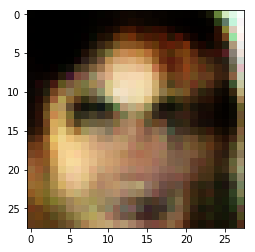

Epoch 1/1... Discriminator Loss: 0.1922... Generator Loss: 3.0638
Epoch 1/1... Discriminator Loss: 0.9166... Generator Loss: 3.4344
Epoch 1/1... Discriminator Loss: 0.1895... Generator Loss: 2.9497
Epoch 1/1... Discriminator Loss: 0.2391... Generator Loss: 2.1409
Epoch 1/1... Discriminator Loss: 0.0864... Generator Loss: 4.2192
Epoch 1/1... Discriminator Loss: 0.4662... Generator Loss: 1.3493
Epoch 1/1... Discriminator Loss: 0.2714... Generator Loss: 3.0830
Epoch 1/1... Discriminator Loss: 0.2727... Generator Loss: 1.9017
Epoch 1/1... Discriminator Loss: 0.1121... Generator Loss: 3.4789
Epoch 1/1... Discriminator Loss: 0.2220... Generator Loss: 2.3394


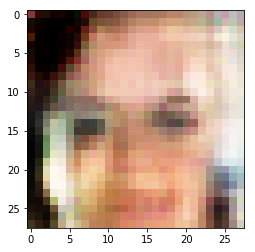

Epoch 1/1... Discriminator Loss: 0.1809... Generator Loss: 3.0211
Epoch 1/1... Discriminator Loss: 0.4645... Generator Loss: 5.1158
Epoch 1/1... Discriminator Loss: 0.2901... Generator Loss: 1.8920
Epoch 1/1... Discriminator Loss: 0.1488... Generator Loss: 3.2582
Epoch 1/1... Discriminator Loss: 0.4191... Generator Loss: 1.4808
Epoch 1/1... Discriminator Loss: 0.2971... Generator Loss: 4.0823
Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 6.4998
Epoch 1/1... Discriminator Loss: 0.0990... Generator Loss: 2.9599
Epoch 1/1... Discriminator Loss: 0.2470... Generator Loss: 1.8755
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 0.8207


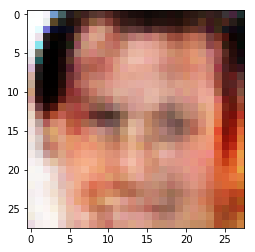

Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 0.0559... Generator Loss: 6.1124
Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 3.4880
Epoch 1/1... Discriminator Loss: 0.3115... Generator Loss: 4.2932
Epoch 1/1... Discriminator Loss: 0.3466... Generator Loss: 1.8936
Epoch 1/1... Discriminator Loss: 0.0960... Generator Loss: 3.9853
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 5.0232
Epoch 1/1... Discriminator Loss: 0.4920... Generator Loss: 1.5521
Epoch 1/1... Discriminator Loss: 0.1695... Generator Loss: 3.3268
Epoch 1/1... Discriminator Loss: 0.2552... Generator Loss: 2.1848


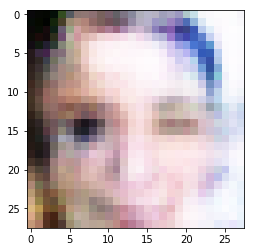

Epoch 1/1... Discriminator Loss: 0.2382... Generator Loss: 2.1333
Epoch 1/1... Discriminator Loss: 0.2462... Generator Loss: 2.3050
Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 3.4675
Epoch 1/1... Discriminator Loss: 0.2813... Generator Loss: 2.3663
Epoch 1/1... Discriminator Loss: 0.1547... Generator Loss: 4.6692
Epoch 1/1... Discriminator Loss: 0.1494... Generator Loss: 3.8145
Epoch 1/1... Discriminator Loss: 0.2055... Generator Loss: 2.6515
Epoch 1/1... Discriminator Loss: 0.3077... Generator Loss: 1.8741
Epoch 1/1... Discriminator Loss: 0.1070... Generator Loss: 8.7827
Epoch 1/1... Discriminator Loss: 0.1797... Generator Loss: 3.4870


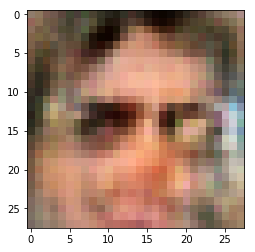

Epoch 1/1... Discriminator Loss: 0.0854... Generator Loss: 3.5893
Epoch 1/1... Discriminator Loss: 0.0767... Generator Loss: 4.5035
Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 7.0898
Epoch 1/1... Discriminator Loss: 0.1985... Generator Loss: 2.9284
Epoch 1/1... Discriminator Loss: 0.2348... Generator Loss: 2.2601
Epoch 1/1... Discriminator Loss: 0.3331... Generator Loss: 1.5830
Epoch 1/1... Discriminator Loss: 0.1479... Generator Loss: 3.5714
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.5042
Epoch 1/1... Discriminator Loss: 0.0627... Generator Loss: 4.6658
Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 5.7618


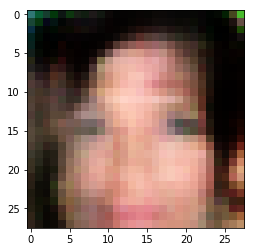

Epoch 1/1... Discriminator Loss: 0.2367... Generator Loss: 2.1717
Epoch 1/1... Discriminator Loss: 0.3967... Generator Loss: 1.5167
Epoch 1/1... Discriminator Loss: 0.2541... Generator Loss: 4.6898
Epoch 1/1... Discriminator Loss: 0.1365... Generator Loss: 4.3521
Epoch 1/1... Discriminator Loss: 0.1234... Generator Loss: 3.6118
Epoch 1/1... Discriminator Loss: 0.2383... Generator Loss: 2.0974
Epoch 1/1... Discriminator Loss: 0.1041... Generator Loss: 4.6204
Epoch 1/1... Discriminator Loss: 2.2420... Generator Loss: 3.4735
Epoch 1/1... Discriminator Loss: 0.7519... Generator Loss: 2.7438
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 1.1857


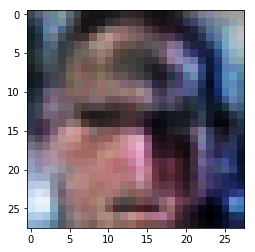

Epoch 1/1... Discriminator Loss: 0.1966... Generator Loss: 2.2319
Epoch 1/1... Discriminator Loss: 0.4759... Generator Loss: 1.2260
Epoch 1/1... Discriminator Loss: 0.2597... Generator Loss: 2.3361
Epoch 1/1... Discriminator Loss: 0.3293... Generator Loss: 1.6716
Epoch 1/1... Discriminator Loss: 0.6468... Generator Loss: 1.0526
Epoch 1/1... Discriminator Loss: 0.0824... Generator Loss: 3.9383
Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 3.0685
Epoch 1/1... Discriminator Loss: 0.2334... Generator Loss: 1.9296
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.4233
Epoch 1/1... Discriminator Loss: 0.4545... Generator Loss: 1.4041


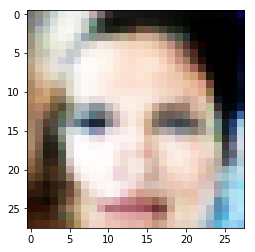

Epoch 1/1... Discriminator Loss: 0.5217... Generator Loss: 1.3023
Epoch 1/1... Discriminator Loss: 0.1660... Generator Loss: 4.7838
Epoch 1/1... Discriminator Loss: 0.1088... Generator Loss: 3.9173
Epoch 1/1... Discriminator Loss: 0.6042... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 0.4256... Generator Loss: 3.7337
Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 0.3653... Generator Loss: 1.7276
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 0.4041... Generator Loss: 1.5384
Epoch 1/1... Discriminator Loss: 0.2162... Generator Loss: 2.4864


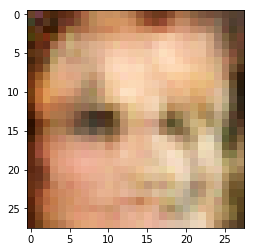

Epoch 1/1... Discriminator Loss: 0.1418... Generator Loss: 3.0450
Epoch 1/1... Discriminator Loss: 0.4322... Generator Loss: 1.4104
Epoch 1/1... Discriminator Loss: 0.0812... Generator Loss: 3.6734
Epoch 1/1... Discriminator Loss: 3.2466... Generator Loss: 0.0783
Epoch 1/1... Discriminator Loss: 0.0824... Generator Loss: 5.3370
Epoch 1/1... Discriminator Loss: 0.1725... Generator Loss: 2.7553
Epoch 1/1... Discriminator Loss: 0.3643... Generator Loss: 1.5980
Epoch 1/1... Discriminator Loss: 0.2555... Generator Loss: 2.0562
Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 4.1739


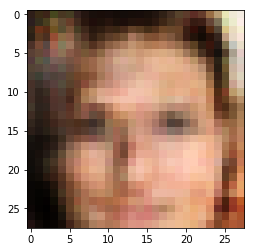

Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 4.0470
Epoch 1/1... Discriminator Loss: 0.4292... Generator Loss: 1.4284
Epoch 1/1... Discriminator Loss: 0.3780... Generator Loss: 3.5730
Epoch 1/1... Discriminator Loss: 0.0822... Generator Loss: 3.5775
Epoch 1/1... Discriminator Loss: 0.1549... Generator Loss: 2.4782
Epoch 1/1... Discriminator Loss: 0.2073... Generator Loss: 3.5331
Epoch 1/1... Discriminator Loss: 0.1417... Generator Loss: 7.0608
Epoch 1/1... Discriminator Loss: 0.1414... Generator Loss: 2.8568
Epoch 1/1... Discriminator Loss: 0.1880... Generator Loss: 4.7633
Epoch 1/1... Discriminator Loss: 0.0795... Generator Loss: 4.1059


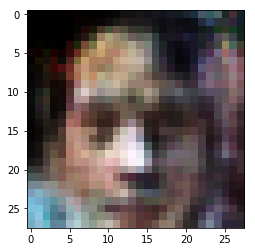

Epoch 1/1... Discriminator Loss: 0.0770... Generator Loss: 4.5936
Epoch 1/1... Discriminator Loss: 0.2400... Generator Loss: 1.9294
Epoch 1/1... Discriminator Loss: 0.1275... Generator Loss: 3.8014
Epoch 1/1... Discriminator Loss: 0.1745... Generator Loss: 3.1303
Epoch 1/1... Discriminator Loss: 0.1727... Generator Loss: 2.4316
Epoch 1/1... Discriminator Loss: 0.1115... Generator Loss: 3.1073
Epoch 1/1... Discriminator Loss: 0.2054... Generator Loss: 2.3074
Epoch 1/1... Discriminator Loss: 0.2330... Generator Loss: 2.2990
Epoch 1/1... Discriminator Loss: 0.1498... Generator Loss: 3.3713
Epoch 1/1... Discriminator Loss: 0.0596... Generator Loss: 3.7054


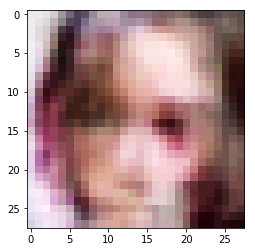

Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 2.7191
Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.0234
Epoch 1/1... Discriminator Loss: 0.3432... Generator Loss: 2.8495
Epoch 1/1... Discriminator Loss: 0.2962... Generator Loss: 4.4634
Epoch 1/1... Discriminator Loss: 1.6190... Generator Loss: 0.3559
Epoch 1/1... Discriminator Loss: 0.1289... Generator Loss: 4.1685
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.5464
Epoch 1/1... Discriminator Loss: 0.2966... Generator Loss: 2.4880
Epoch 1/1... Discriminator Loss: 0.3220... Generator Loss: 1.8057
Epoch 1/1... Discriminator Loss: 0.5796... Generator Loss: 1.0100


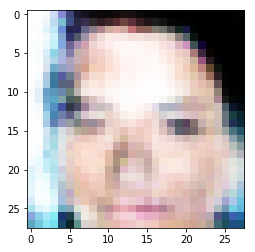

Epoch 1/1... Discriminator Loss: 0.2886... Generator Loss: 1.7776
Epoch 1/1... Discriminator Loss: 0.1082... Generator Loss: 3.0741
Epoch 1/1... Discriminator Loss: 0.2028... Generator Loss: 2.3162
Epoch 1/1... Discriminator Loss: 2.3178... Generator Loss: 0.1748
Epoch 1/1... Discriminator Loss: 0.9647... Generator Loss: 2.8299
Epoch 1/1... Discriminator Loss: 0.6216... Generator Loss: 1.9120
Epoch 1/1... Discriminator Loss: 0.0818... Generator Loss: 4.6694
Epoch 1/1... Discriminator Loss: 0.3230... Generator Loss: 1.7997
Epoch 1/1... Discriminator Loss: 0.0559... Generator Loss: 4.1267
Epoch 1/1... Discriminator Loss: 0.1654... Generator Loss: 6.0146


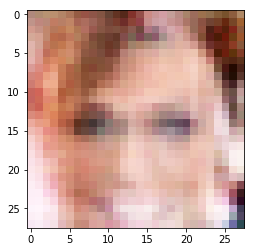

Epoch 1/1... Discriminator Loss: 0.0649... Generator Loss: 4.4163
Epoch 1/1... Discriminator Loss: 0.2371... Generator Loss: 2.0507
Epoch 1/1... Discriminator Loss: 0.0872... Generator Loss: 3.9033
Epoch 1/1... Discriminator Loss: 0.1023... Generator Loss: 3.5170
Epoch 1/1... Discriminator Loss: 0.1107... Generator Loss: 3.1637
Epoch 1/1... Discriminator Loss: 0.0307... Generator Loss: 6.5227
Epoch 1/1... Discriminator Loss: 0.0696... Generator Loss: 3.7537
Epoch 1/1... Discriminator Loss: 0.8767... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 0.2834... Generator Loss: 2.2347
Epoch 1/1... Discriminator Loss: 0.2205... Generator Loss: 2.3292


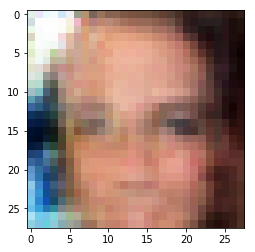

Epoch 1/1... Discriminator Loss: 0.3914... Generator Loss: 1.6882
Epoch 1/1... Discriminator Loss: 0.0307... Generator Loss: 5.6293
Epoch 1/1... Discriminator Loss: 0.1896... Generator Loss: 2.3129
Epoch 1/1... Discriminator Loss: 0.0790... Generator Loss: 3.5200
Epoch 1/1... Discriminator Loss: 0.0776... Generator Loss: 3.6967
Epoch 1/1... Discriminator Loss: 0.0278... Generator Loss: 9.0731
Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 2.4475
Epoch 1/1... Discriminator Loss: 0.1984... Generator Loss: 2.3402
Epoch 1/1... Discriminator Loss: 0.0609... Generator Loss: 3.6228
Epoch 1/1... Discriminator Loss: 0.0730... Generator Loss: 3.5132


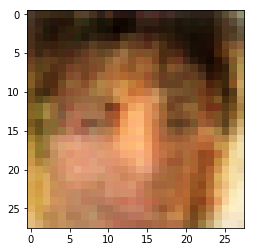

Epoch 1/1... Discriminator Loss: 0.0423... Generator Loss: 4.9338
Epoch 1/1... Discriminator Loss: 0.0586... Generator Loss: 7.7725
Epoch 1/1... Discriminator Loss: 0.0213... Generator Loss: 6.6885
Epoch 1/1... Discriminator Loss: 0.0350... Generator Loss: 6.9151
Epoch 1/1... Discriminator Loss: 0.0432... Generator Loss: 6.0588
Epoch 1/1... Discriminator Loss: 0.0251... Generator Loss: 7.0301
Epoch 1/1... Discriminator Loss: 0.5198... Generator Loss: 1.2259
Epoch 1/1... Discriminator Loss: 0.1045... Generator Loss: 6.7148
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 0.2350... Generator Loss: 2.3890


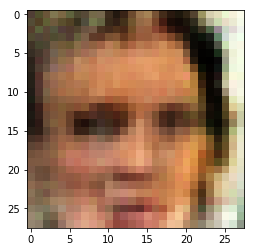

Epoch 1/1... Discriminator Loss: 0.5371... Generator Loss: 3.2219
Epoch 1/1... Discriminator Loss: 0.3588... Generator Loss: 2.2431
Epoch 1/1... Discriminator Loss: 0.2233... Generator Loss: 2.4367
Epoch 1/1... Discriminator Loss: 2.1558... Generator Loss: 0.2284
Epoch 1/1... Discriminator Loss: 1.0811... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 0.3858... Generator Loss: 2.5376
Epoch 1/1... Discriminator Loss: 0.0528... Generator Loss: 4.6155
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 1.2350
Epoch 1/1... Discriminator Loss: 0.5285... Generator Loss: 2.4035
Epoch 1/1... Discriminator Loss: 0.8228... Generator Loss: 0.8104


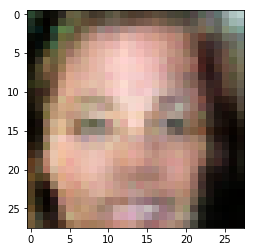

Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 0.3523... Generator Loss: 1.6182
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 0.1841... Generator Loss: 2.5700
Epoch 1/1... Discriminator Loss: 0.2255... Generator Loss: 2.5363
Epoch 1/1... Discriminator Loss: 0.2168... Generator Loss: 2.3549
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 2.5068
Epoch 1/1... Discriminator Loss: 0.3317... Generator Loss: 1.7987
Epoch 1/1... Discriminator Loss: 0.1522... Generator Loss: 3.2072
Epoch 1/1... Discriminator Loss: 0.2752... Generator Loss: 2.3978


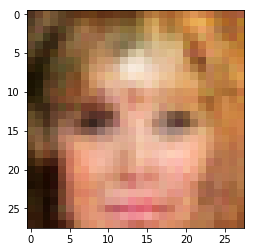

Epoch 1/1... Discriminator Loss: 0.0912... Generator Loss: 4.3080
Epoch 1/1... Discriminator Loss: 0.3786... Generator Loss: 1.5596
Epoch 1/1... Discriminator Loss: 2.7388... Generator Loss: 0.1190
Epoch 1/1... Discriminator Loss: 1.7317... Generator Loss: 0.2890
Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 0.9359
Epoch 1/1... Discriminator Loss: 0.5407... Generator Loss: 1.4772
Epoch 1/1... Discriminator Loss: 0.2826... Generator Loss: 2.0727
Epoch 1/1... Discriminator Loss: 0.3018... Generator Loss: 2.0575
Epoch 1/1... Discriminator Loss: 0.2993... Generator Loss: 1.9732
Epoch 1/1... Discriminator Loss: 0.2574... Generator Loss: 2.1216


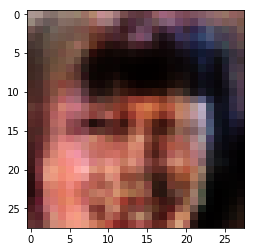

Epoch 1/1... Discriminator Loss: 0.1963... Generator Loss: 3.9157
Epoch 1/1... Discriminator Loss: 0.5449... Generator Loss: 1.1397
Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 1.0944
Epoch 1/1... Discriminator Loss: 0.1372... Generator Loss: 3.0191
Epoch 1/1... Discriminator Loss: 0.3726... Generator Loss: 1.5250
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.3677
Epoch 1/1... Discriminator Loss: 0.2342... Generator Loss: 2.0177
Epoch 1/1... Discriminator Loss: 0.6024... Generator Loss: 3.0555
Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 1.3149
Epoch 1/1... Discriminator Loss: 0.3338... Generator Loss: 2.4518


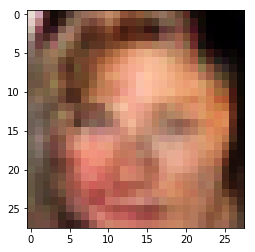

Epoch 1/1... Discriminator Loss: 0.6388... Generator Loss: 1.2666
Epoch 1/1... Discriminator Loss: 0.6702... Generator Loss: 1.1260
Epoch 1/1... Discriminator Loss: 0.0780... Generator Loss: 4.0726
Epoch 1/1... Discriminator Loss: 0.2872... Generator Loss: 2.1461
Epoch 1/1... Discriminator Loss: 0.3164... Generator Loss: 1.9494
Epoch 1/1... Discriminator Loss: 0.2500... Generator Loss: 2.8698
Epoch 1/1... Discriminator Loss: 0.4343... Generator Loss: 1.3422
Epoch 1/1... Discriminator Loss: 0.8591... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 2.7360... Generator Loss: 2.5748
Epoch 1/1... Discriminator Loss: 0.5900... Generator Loss: 1.4491


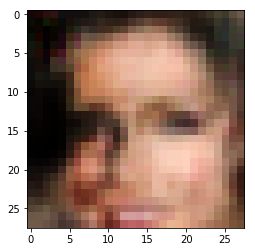

Epoch 1/1... Discriminator Loss: 0.1409... Generator Loss: 4.4909
Epoch 1/1... Discriminator Loss: 0.3179... Generator Loss: 2.1750
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.4496
Epoch 1/1... Discriminator Loss: 0.2071... Generator Loss: 2.3547
Epoch 1/1... Discriminator Loss: 0.2811... Generator Loss: 2.7755
Epoch 1/1... Discriminator Loss: 0.5035... Generator Loss: 1.3531
Epoch 1/1... Discriminator Loss: 0.5374... Generator Loss: 2.1461
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 0.2358... Generator Loss: 2.5906
Epoch 1/1... Discriminator Loss: 0.1176... Generator Loss: 3.7736


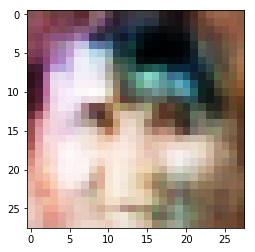

Epoch 1/1... Discriminator Loss: 0.2839... Generator Loss: 1.9258
Epoch 1/1... Discriminator Loss: 0.2637... Generator Loss: 2.3419
Epoch 1/1... Discriminator Loss: 0.3116... Generator Loss: 1.8323
Epoch 1/1... Discriminator Loss: 0.1666... Generator Loss: 3.2545
Epoch 1/1... Discriminator Loss: 0.1962... Generator Loss: 3.4326
Epoch 1/1... Discriminator Loss: 0.3025... Generator Loss: 2.5290
Epoch 1/1... Discriminator Loss: 0.4662... Generator Loss: 1.4710
Epoch 1/1... Discriminator Loss: 0.5821... Generator Loss: 1.1614
Epoch 1/1... Discriminator Loss: 1.4266... Generator Loss: 0.3807
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 0.5139


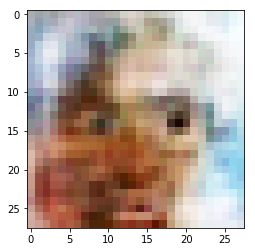

Epoch 1/1... Discriminator Loss: 0.1132... Generator Loss: 4.7377
Epoch 1/1... Discriminator Loss: 0.1033... Generator Loss: 4.9449
Epoch 1/1... Discriminator Loss: 0.6880... Generator Loss: 0.9726
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.3273
Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 0.3433... Generator Loss: 1.5430
Epoch 1/1... Discriminator Loss: 0.1537... Generator Loss: 2.9087
Epoch 1/1... Discriminator Loss: 0.4653... Generator Loss: 1.3544
Epoch 1/1... Discriminator Loss: 0.1799... Generator Loss: 2.3340
Epoch 1/1... Discriminator Loss: 0.2393... Generator Loss: 2.1888


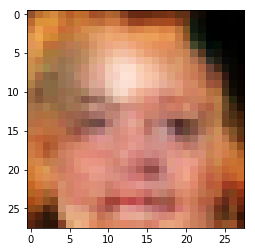

Epoch 1/1... Discriminator Loss: 0.0819... Generator Loss: 3.9780
Epoch 1/1... Discriminator Loss: 0.2690... Generator Loss: 2.6473
Epoch 1/1... Discriminator Loss: 0.6441... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 0.4519... Generator Loss: 1.2864
Epoch 1/1... Discriminator Loss: 0.7080... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 0.0851... Generator Loss: 3.4150
Epoch 1/1... Discriminator Loss: 0.3267... Generator Loss: 1.5517
Epoch 1/1... Discriminator Loss: 0.4498... Generator Loss: 1.8952
Epoch 1/1... Discriminator Loss: 0.4805... Generator Loss: 1.6607
Epoch 1/1... Discriminator Loss: 0.3240... Generator Loss: 2.0658


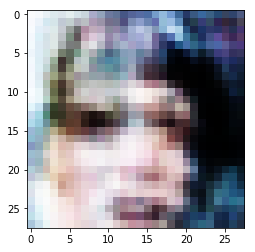

Epoch 1/1... Discriminator Loss: 0.7205... Generator Loss: 2.3289
Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 0.1992... Generator Loss: 2.9854
Epoch 1/1... Discriminator Loss: 0.2275... Generator Loss: 1.9897
Epoch 1/1... Discriminator Loss: 1.0162... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 0.2665... Generator Loss: 1.8649
Epoch 1/1... Discriminator Loss: 0.1076... Generator Loss: 2.9280
Epoch 1/1... Discriminator Loss: 0.2890... Generator Loss: 1.9444
Epoch 1/1... Discriminator Loss: 0.6991... Generator Loss: 0.9719
Epoch 1/1... Discriminator Loss: 0.2345... Generator Loss: 4.1418


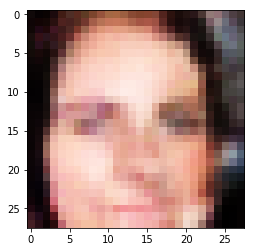

Epoch 1/1... Discriminator Loss: 0.2057... Generator Loss: 2.9032
Epoch 1/1... Discriminator Loss: 0.1936... Generator Loss: 2.3671
Epoch 1/1... Discriminator Loss: 0.1758... Generator Loss: 2.6455
Epoch 1/1... Discriminator Loss: 0.2328... Generator Loss: 1.9570
Epoch 1/1... Discriminator Loss: 0.3554... Generator Loss: 1.6230
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 0.5860
Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 0.8685
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 2.7688
Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 2.3010
Epoch 1/1... Discriminator Loss: 0.4487... Generator Loss: 1.4406


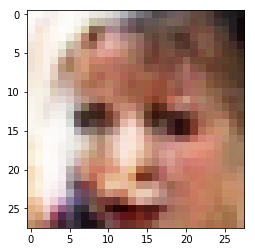

Epoch 1/1... Discriminator Loss: 0.5828... Generator Loss: 4.0334
Epoch 1/1... Discriminator Loss: 0.2019... Generator Loss: 2.3464
Epoch 1/1... Discriminator Loss: 0.6943... Generator Loss: 2.1022
Epoch 1/1... Discriminator Loss: 0.2146... Generator Loss: 2.6313
Epoch 1/1... Discriminator Loss: 0.0644... Generator Loss: 6.0980
Epoch 1/1... Discriminator Loss: 0.2816... Generator Loss: 2.0526
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.5711
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 0.4230... Generator Loss: 1.4074
Epoch 1/1... Discriminator Loss: 0.5622... Generator Loss: 1.0586


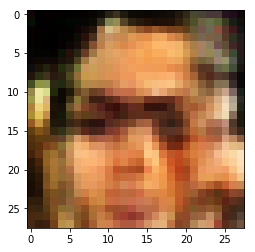

Epoch 1/1... Discriminator Loss: 0.2416... Generator Loss: 3.2380
Epoch 1/1... Discriminator Loss: 0.5607... Generator Loss: 1.4145
Epoch 1/1... Discriminator Loss: 0.1106... Generator Loss: 6.5941
Epoch 1/1... Discriminator Loss: 0.8004... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.8197... Generator Loss: 0.2370
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.4492
Epoch 1/1... Discriminator Loss: 0.0772... Generator Loss: 4.3028
Epoch 1/1... Discriminator Loss: 0.3189... Generator Loss: 2.2871
Epoch 1/1... Discriminator Loss: 0.4218... Generator Loss: 1.6391
Epoch 1/1... Discriminator Loss: 0.2268... Generator Loss: 2.0853


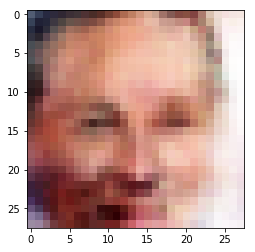

Epoch 1/1... Discriminator Loss: 0.7456... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 0.5967... Generator Loss: 1.0380
Epoch 1/1... Discriminator Loss: 0.3496... Generator Loss: 1.6428
Epoch 1/1... Discriminator Loss: 0.3772... Generator Loss: 1.7734
Epoch 1/1... Discriminator Loss: 0.1337... Generator Loss: 4.0176
Epoch 1/1... Discriminator Loss: 0.5780... Generator Loss: 1.3889
Epoch 1/1... Discriminator Loss: 0.4588... Generator Loss: 1.2681
Epoch 1/1... Discriminator Loss: 0.2015... Generator Loss: 3.8780
Epoch 1/1... Discriminator Loss: 0.7403... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 0.3264... Generator Loss: 1.9908


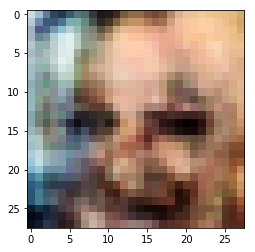

Epoch 1/1... Discriminator Loss: 0.2691... Generator Loss: 2.1656
Epoch 1/1... Discriminator Loss: 2.3546... Generator Loss: 0.1544
Epoch 1/1... Discriminator Loss: 0.6968... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 0.8341... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 0.8168... Generator Loss: 1.0663
Epoch 1/1... Discriminator Loss: 0.8109... Generator Loss: 0.9887
Epoch 1/1... Discriminator Loss: 0.2922... Generator Loss: 2.3364
Epoch 1/1... Discriminator Loss: 0.4841... Generator Loss: 1.4862


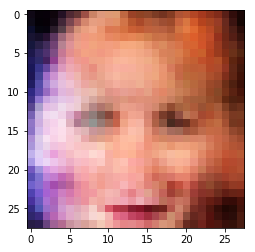

Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.4789
Epoch 1/1... Discriminator Loss: 0.5722... Generator Loss: 1.1141
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.4073
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.4809
Epoch 1/1... Discriminator Loss: 0.6690... Generator Loss: 1.1306
Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 0.7078... Generator Loss: 0.9473
Epoch 1/1... Discriminator Loss: 0.2873... Generator Loss: 2.3594
Epoch 1/1... Discriminator Loss: 0.1014... Generator Loss: 4.0931
Epoch 1/1... Discriminator Loss: 0.1933... Generator Loss: 2.7352


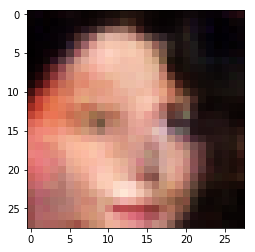

Epoch 1/1... Discriminator Loss: 1.0294... Generator Loss: 0.5911
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.4996
Epoch 1/1... Discriminator Loss: 0.6544... Generator Loss: 1.1529
Epoch 1/1... Discriminator Loss: 0.5546... Generator Loss: 1.3838
Epoch 1/1... Discriminator Loss: 0.0665... Generator Loss: 4.3693
Epoch 1/1... Discriminator Loss: 0.3072... Generator Loss: 2.0956
Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 0.0589... Generator Loss: 5.5476
Epoch 1/1... Discriminator Loss: 0.0296... Generator Loss: 10.7964
Epoch 1/1... Discriminator Loss: 0.2303... Generator Loss: 2.1614


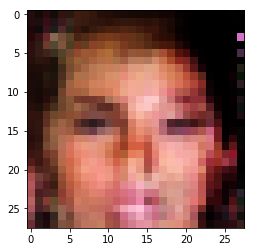

Epoch 1/1... Discriminator Loss: 0.3219... Generator Loss: 2.0434
Epoch 1/1... Discriminator Loss: 0.1123... Generator Loss: 5.5710
Epoch 1/1... Discriminator Loss: 0.3210... Generator Loss: 1.6205
Epoch 1/1... Discriminator Loss: 0.5509... Generator Loss: 1.4858
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 0.2241... Generator Loss: 2.7289
Epoch 1/1... Discriminator Loss: 2.0595... Generator Loss: 3.5658
Epoch 1/1... Discriminator Loss: 0.1861... Generator Loss: 3.7183
Epoch 1/1... Discriminator Loss: 0.4724... Generator Loss: 1.3236
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.4381


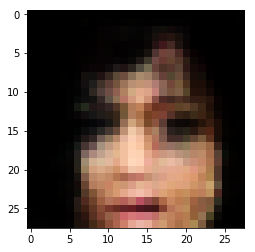

Epoch 1/1... Discriminator Loss: 0.3133... Generator Loss: 2.4368
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.4124
Epoch 1/1... Discriminator Loss: 0.2047... Generator Loss: 2.5186
Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 0.2546... Generator Loss: 2.0006
Epoch 1/1... Discriminator Loss: 0.6625... Generator Loss: 1.0159
Epoch 1/1... Discriminator Loss: 0.0967... Generator Loss: 7.6912
Epoch 1/1... Discriminator Loss: 0.3042... Generator Loss: 1.8043
Epoch 1/1... Discriminator Loss: 0.6035... Generator Loss: 1.1417


KeyboardInterrupt: 

In [76]:
batch_size = 32
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.